In [1]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from dataset import StreetHazardDataset

# Make everything deterministic
seed = 24
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = torch.hub.load("./dinov3", 'dinov3_vits16', source='local', weights="https://dinov3.llamameta.net/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiNGZqbnc4dXdxb21zNHh3dm0xbTZ4anF2IiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTU3MDU1NTl9fX1dfQ__&Signature=LJ5NrLId6%7Ey6opPJXXPh6q8rEj%7EFRUlD3WkMR3tlZ9ELqeQJDs46f16bzRFPbkHDttYNJqpemZqSNkiPhWrr6KtCA3KNPRjYxerHDlhO7f72Eq6U8owR6RisyP1evJVzyAI3qnbYdb7yIQcNBRkElkhpYwEJRNQLvTo1RR1kqc5G6Hdbe2ngBvEzCmcBKaijImxqaz-J7pPSgLOUtU3%7ERqlglfptkOy3KNmlu0Ib3fd2olH2fYFimC7bN1hBLJn7AH-JmEyLc1zLILNNOL03zj%7E7X8nCRxLZa3kLqN%7E4CrPdKQbNhGXEkZ9N3pq71Fk9pwRDZGLQgCYB8PeASh4r4Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1107184587434197")
model.eval()

c:\Users\Luca\Desktop\MagistraleAI\2nd_year\Machine Learning for Computer Vision\Assignment\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerN

In [2]:
import torchvision.transforms as T
from PIL import Image

annotations_train_file = "./data/train/train.odgt"
annotations_test_file = "./data/test/test.odgt"
img_dir = "./data/train"
PIXEL_PER_CLASS = 3
IMAGE_SIZE = (512,512)
ORIGINAL_IMAGE_SIZE = (720, 1280)


image_transform = T.Compose([
    T.Resize(ORIGINAL_IMAGE_SIZE, interpolation=Image.BICUBIC),  # Resize to 224x224
    T.ToTensor(),  # Converts to [0,1], also converts HWC -> CHW
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose(
    [
        transforms.Resize(ORIGINAL_IMAGE_SIZE, interpolation=InterpolationMode.NEAREST),
    ]
)


dataset_train = StreetHazardDataset(
    annotations_train_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=True,
    pixel_per_class=PIXEL_PER_CLASS
)

dataset_test = StreetHazardDataset(
    annotations_test_file,
    "./data/test",
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=True,
    pixel_per_class=PIXEL_PER_CLASS
)


In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

NUM_CLASSES = 14
INDEX = 1
NUM_COMPONENTS = 2
NUM_IMAGES = 2
embeddings = {c: [] for c in range(NUM_CLASSES)}
indices = torch.randperm(len(dataset_test))[:NUM_IMAGES]  # Randomly select NUM_IMAGES from the dataset

# for i, (image, segmentation, _) in enumerate(dataset_train):
    # i+=1
    # if i < INDEX:    
    #     continue
for i in indices:
    image, segmentation, _ = dataset_test[i]
    image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(image, is_training=True)["x_norm_patchtokens"]
        B, HW, C = features.shape
        # H = W = int(HW ** 0.5)
        H,W = ORIGINAL_IMAGE_SIZE[0] // 16, ORIGINAL_IMAGE_SIZE[1] // 16
        features = features.reshape(B, H, W, C)
        features = features.permute(0, 3, 1, 2)  # Change to B, C, H, W
        # Interpolate to image size
        features = torch.nn.functional.interpolate(features, size=ORIGINAL_IMAGE_SIZE, mode="bilinear")[0]

        for c in range(NUM_CLASSES):
            mask = segmentation == c
            # Select all the embeddings for the current class
            class_embeddings = features[:, mask]
            embeddings[c].append(class_embeddings)
        # Normalize the embeddings
        # features = features / features.norm(dim=1, keepdim=True)

    # features = features.reshape(C, -1).permute(1, 0)  # Change to H*W, C
    # pca = PCA(n_components=NUM_COMPONENTS)
    # features_pca = pca.fit_transform(features.cpu().numpy())
    # features_pca = torch.from_numpy(features_pca.reshape(ORIGINAL_IMAGE_SIZE[0], ORIGINAL_IMAGE_SIZE[1], NUM_COMPONENTS)).permute(2, 0, 1)


    # for c in range(NUM_CLASSES):
    #     # mask = segmentation == c
    #     mask = torch.ones_like(segmentation, dtype=torch.bool)
    #     # Select all the embeddings for the current class
    #     class_embeddings = features_pca[:, mask]
    #     # Compute average and std
    #     class_embeddings_avg = class_embeddings.mean(dim=1)
    #     class_embeddings_std = class_embeddings.std(dim=1)
    #     # Compute average cosine similarity
    #     # class_embeddings_cosine_sim = class_embeddings.T @ class_embeddings
    #     # print(class_embeddings_cosine_sim.shape)
        
    #     print(class_embeddings.shape, class_embeddings_avg.shape, class_embeddings_std.shape)
    #     print(class_embeddings_std.norm())


    # break  # Just to show one sample

In [16]:
embeddings[0][0].shape # (Emb dim, N)

# Concatenate the embeddings for each class
embeddings = {c: torch.cat(embeddings[c], dim=1) for c in range(NUM_CLASSES)}

In [17]:
embeddings_merged = torch.cat([embeddings[c] for c in range(NUM_CLASSES)], dim=1)
print(embeddings_merged.shape)  # (Emb dim, N)

# Apply PCA
pca = PCA(n_components=NUM_COMPONENTS)
embeddings_pca = pca.fit_transform(embeddings_merged.cpu().numpy().transpose(1, 0)).transpose(1, 0)
embeddings_pca = torch.from_numpy(embeddings_pca).to(embeddings_merged.device)
print(embeddings_pca.shape)  # (NUM_COMPONENTS, N)

# Divide embeddings back into classes
embeddings_per_class = {}
n = 0
for c in range(NUM_CLASSES):
    print(embeddings[c].shape[1])
    embeddings_per_class[c] = embeddings_pca[:, n:n + embeddings[c].shape[1]]
    n += embeddings[c].shape[1]

torch.Size([384, 1843200])
torch.Size([2, 1843200])
617336
174555
10666
54877
0
9059
46987
639793
75848
137054
22
2226
3054
71723


In [18]:
# mean and std regardless of the class
embeddings_pca.std(dim=1).norm()

tensor(3.3071)

Class 0: Std = 2.1297268867492676
Class 1: Std = 1.6768347024917603
Class 2: Std = 0.367229163646698
Class 3: Std = 0.8969764709472656
Class 4: Std = nan
Class 5: Std = 1.4623770713806152
Class 6: Std = 1.8996425867080688
Class 7: Std = 2.1393942832946777
Class 8: Std = 1.5673940181732178
Class 9: Std = 2.1140990257263184
Class 10: Std = 0.264379620552063
Class 11: Std = 0.7527369260787964
Class 12: Std = 0.89162278175354
Class 13: Std = 1.3688627481460571
Mean std: 1.348559856414795


C:\Users\Luca\AppData\Local\Temp\ipykernel_15528\425393573.py:5: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  std = embeddings_per_class[c].std(dim=1).norm()


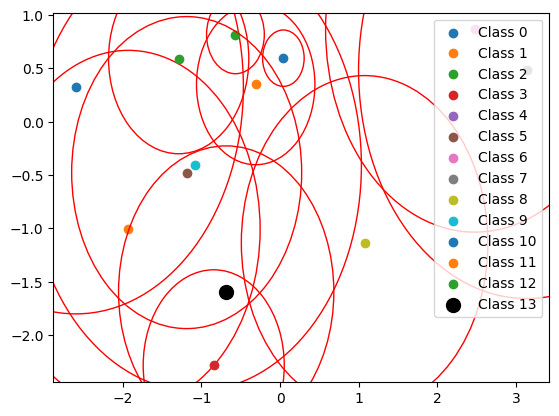

In [19]:
# For each class, compute mean and std
stds = []
for c in range(NUM_CLASSES):
    mean = embeddings_per_class[c].mean(dim=1)
    std = embeddings_per_class[c].std(dim=1).norm()
    print(f"Class {c}: Std = {std}")
    if std > 0:
        stds.append(std)
    # Scatter the mean
    if c == 13:
        plt.scatter(mean[0].cpu().numpy(), mean[1].cpu().numpy(), label=f"Class {c}", s=100, color='black')
    else:
        plt.scatter(mean[0].cpu().numpy(), mean[1].cpu().numpy(), label=f"Class {c}")
    # Draw a circle using std
    circle = plt.Circle((mean[0].cpu().numpy(), mean[1].cpu().numpy()), std.cpu().numpy(), color='r', fill=False)
    plt.gca().add_artist(circle)

print(f"Mean std: {torch.tensor(stds).mean()}")
plt.legend()

torch.Size([1, 3600, 384])
(3600, 384)
(3600, 3)
(3600, 3)


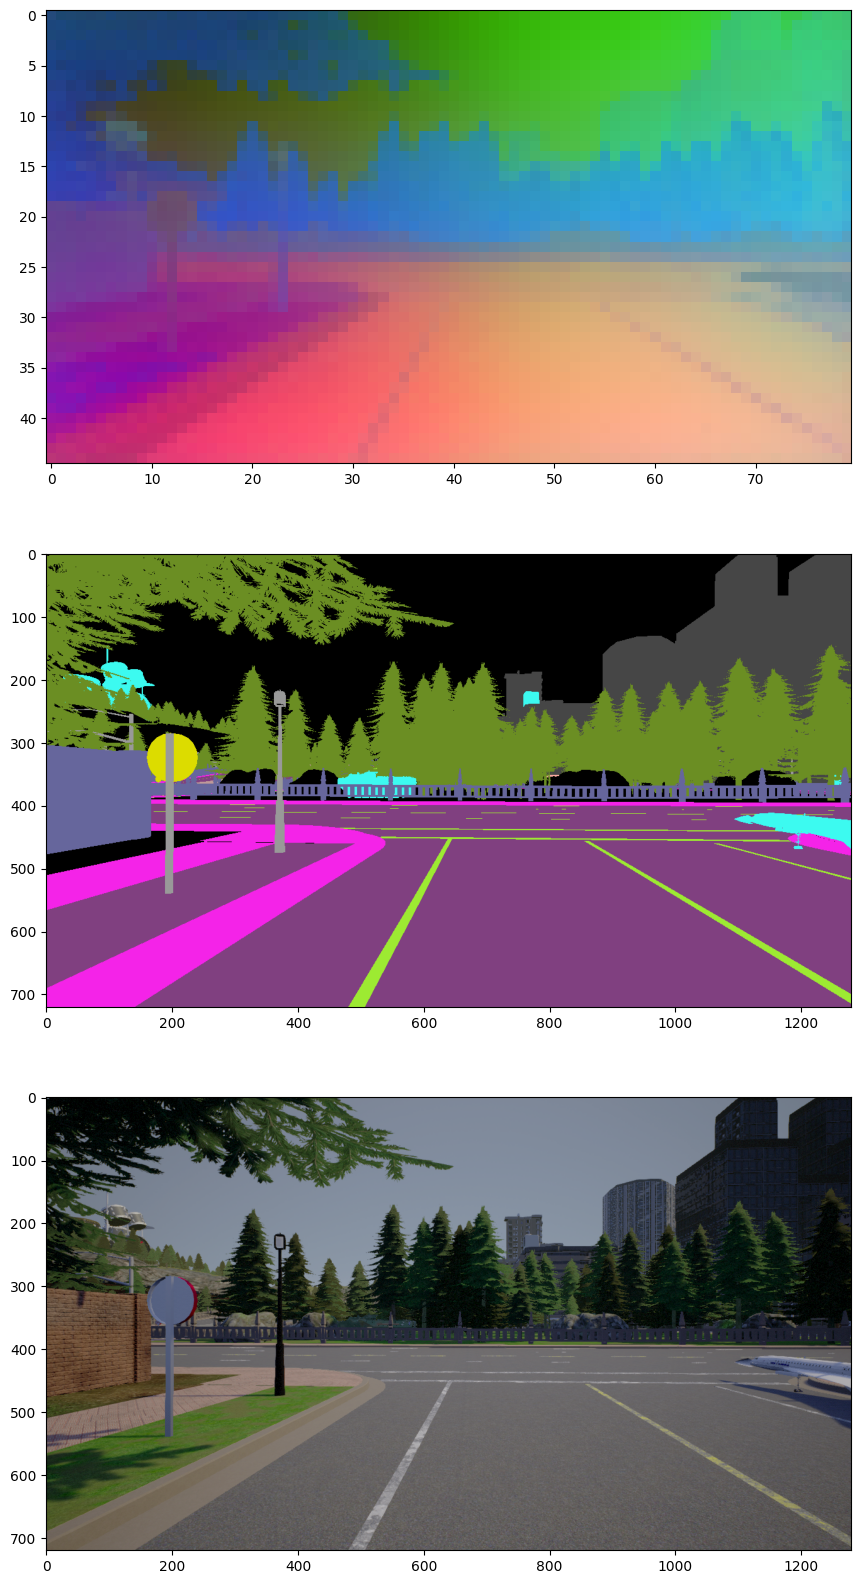

In [138]:
# Apply PCA to the last dimension of y
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
from plot import color

INDEX = 60
x = dataset_test[INDEX][0].unsqueeze(0)  # Add batch dimension
x_denorm = x * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
segmentation = dataset_test[INDEX][1]  # Add batch dimension

y = model(x, is_training=True)
y = y["x_norm_patchtokens"]
B, num_patches, d_model = y.shape
_, _, H, W = x.shape
print(y.shape)


pca = PCA(n_components=3)
H, W = H // 16, W // 16
result_image = np.zeros((H, W, 3))

print(y[0].detach().numpy().shape)
patch_color = pca.fit_transform(y[0].detach().numpy())
print(patch_color.shape)
patch_color = (patch_color - patch_color.min()) / (
    patch_color.max() - patch_color.min()
)
print(patch_color.shape)

for i in range(H):
    for j in range(W):
        n = i * W + j
        result_image[i, j] = patch_color[n]

result_image = result_image.reshape(H, W, 3)
plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
plt.imshow(result_image)
plt.subplot(3, 1, 2)
# Plot the segmentation
plt.imshow(color(segmentation.cpu().numpy()))
plt.subplot(3, 1, 3)
# Plot the image
plt.imshow(x_denorm[0].detach().numpy().transpose(1, 2, 0))
